In [1]:
import os

from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings



from IPython.display import display

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "lte_signal_to_noise_ratio"

**NOTE**: See the profiled `ltv_signal_to_noise_ratio` [here](https://storage.googleapis.com/anduril-case-study/metrics/lte_signal_to_noise_ratio.html).

In [2]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.{METRIC}",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  86105 non-null  float64
 1   tower_B  21539 non-null  float64
 2   tower_C  20654 non-null  float64
 3   tower_D  21437 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [4]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,86105.000000,21539.000000,20654.000000,21437.000000
mean,5.208308,2.255635,-0.309653,4.526733
std,2.068994,2.522206,2.210387,2.361138
min,-4.000000,-5.171429,-7.841667,-2.663636
25%,3.766667,1.016667,-1.608333,3.191667
50%,5.300000,2.241667,-0.166667,4.200000
75%,6.633333,3.675000,1.125000,5.233333
max,13.900000,9.375000,8.752174,19.641667


In [5]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)

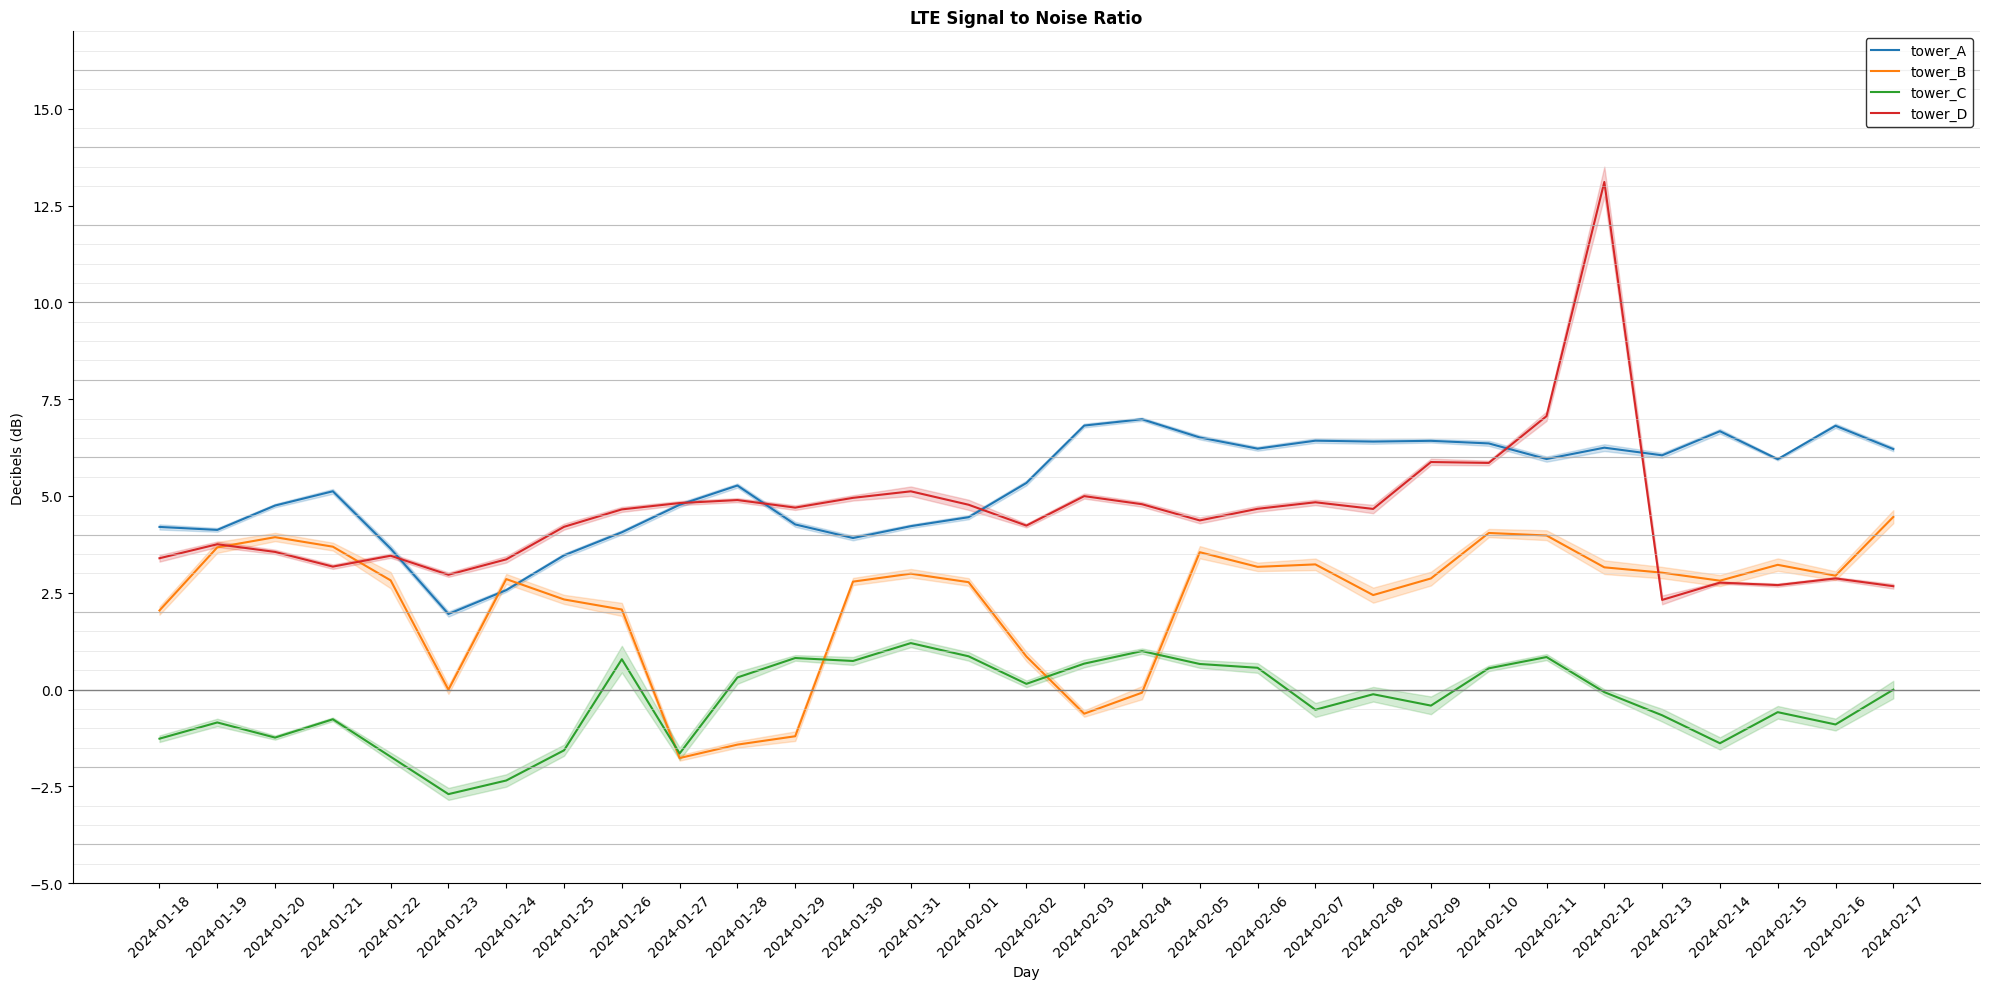

In [28]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='day', y='value', hue='variable', data=df_long)

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.title('LTE Signal to Noise Ratio', weight='bold')
plt.xlabel('Day')
plt.ylabel('Decibels (dB)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [7]:
df.resample('1d').agg(['mean', 'sem'])

tower_A             tower_B             tower_C  \
                               mean       sem      mean       sem      mean   
ts                                                                            
2024-01-18 00:00:00+00:00  4.200702  0.033325  2.042734  0.052685 -1.268075   
2024-01-19 00:00:00+00:00  4.123461  0.025904  3.672375  0.072870 -0.849397   
2024-01-20 00:00:00+00:00  4.752928  0.022491  3.935523  0.057060 -1.239873   
2024-01-21 00:00:00+00:00  5.121400  0.032369  3.690231  0.054558 -0.767233   
2024-01-22 00:00:00+00:00  3.641140  0.038039  2.820090  0.110508 -1.735141   
2024-01-23 00:00:00+00:00  1.952118  0.034494 -0.004113  0.056348 -2.700464   
2024-01-24 00:00:00+00:00  2.568235  0.023956  2.853359  0.067963 -2.348411   
2024-01-25 00:00:00+00:00  3.466424  0.027218  2.327552  0.061915 -1.569211   
2024-01-26 00:00:00+00:00  4.062288  0.027796  2.067292  0.083194  0.783633   
2024-01-27 00:00:00+00:00  4.772847  0.029686 -1.768208  0.037109 -1.650534   
2024-01-28 00:00:00+00:00  5.269925  0.026996 -1.421571  0.043676  0.312783   
2024-01-29 00:00:00+00:00  4.264601  0.034547 -1.205674  0.063956  0.814837   
2024-01-30 00:00:00+00:00  3.914218  0.030593  2.787624  0.049473  0.738595   
2024-01-31 00:00:00+00:00  4.220162  0.025009  2.992655  0.053877  1.200192   
2024-02-01 00:00:00+00:00  4.452009  0.027076  2.773728  0.051160  0.859166   
2024-02-02 00:00:00+00:00  5.335782  0.034642  0.854223  0.062137  0.147771   
2024-02-03 00:00:00+00:00  6.818027  0.025761 -0.622996  0.041904  0.669555   
2024-02-04 00:00:00+00:00  6.981840  0.020813 -0.080825  0.089405  0.993608   
2024-02-05 00:00:00+00:00  6.510841  0.028548  3.547747  0.077478  0.660691   
2024-02-06 00:00:00+00:00  6.221969  0.026762  3.169353  0.057580  0.562763   
2024-02-07 00:00:00+00:00  6.427984  0.029178  3.232853  0.075211 -0.520754   
2024-02-08 00:00:00+00:00  6.404721  0.029074  2.440727  0.098812 -0.120537   
2024-02-09 00:00:00+00:00  6.424167  0.022722  2.870091  0.090285 -0.414279   
2024-02-10 00:00:00+00:00  6.357153  0.032977  4.044384  0.056037  0.548332   
2024-02-11 00:00:00+00:00  5.953977  0.033774  3.979456  0.067312  0.839979   
2024-02-12 00:00:00+00:00  6.247367  0.045302  3.157019  0.089678 -0.066141   
2024-02-13 00:00:00+00:00  6.050332  0.031392  3.019083  0.076250 -0.663849   
2024-02-14 00:00:00+00:00  6.672344  0.032216  2.812103  0.075513 -1.386185   
2024-02-15 00:00:00+00:00  5.949827  0.016490  3.221537  0.082273 -0.583632   
2024-02-16 00:00:00+00:00  6.813154  0.029568  2.941121  0.058224 -0.901160   
2024-02-17 00:00:00+00:00  6.211092  0.027900  4.458270  0.082046 -0.002619   

                                       tower_D            
                                sem       mean       sem  
ts                                                        
2024-01-18 00:00:00+00:00  0.044485   3.391592  0.044505  
2024-01-19 00:00:00+00:00  0.048455   3.753315  0.036305  
2024-01-20 00:00:00+00:00  0.028416   3.555199  0.027972  
2024-01-21 00:00:00+00:00  0.025216   3.175848  0.029454  
2024-01-22 00:00:00+00:00  0.051092   3.456572  0.027844  
2024-01-23 00:00:00+00:00  0.082091   2.964991  0.030131  
2024-01-24 00:00:00+00:00  0.083022   3.362911  0.042925  
2024-01-25 00:00:00+00:00  0.080112   4.203400  0.039690  
2024-01-26 00:00:00+00:00  0.174670   4.653480  0.031942  
2024-01-27 00:00:00+00:00  0.078939   4.817086  0.025682  
2024-01-28 00:00:00+00:00  0.081229   4.894448  0.028006  
2024-01-29 00:00:00+00:00  0.037526   4.699635  0.031988  
2024-01-30 00:00:00+00:00  0.051809   4.951546  0.034314  
2024-01-31 00:00:00+00:00  0.054430   5.119875  0.061539  
2024-02-01 00:00:00+00:00  0.058441   4.773461  0.067881  
2024-02-02 00:00:00+00:00  0.042273   4.234978  0.026741  
2024-02-03 00:00:00+00:00  0.049596   4.995903  0.033218  
2024-02-04 00:00:00+00:00  0.036721   4.787162  0.032921  
2024-02-05 00:00:00+00:00  0.053480   4.368576  0.038528  
2024-02-06 00:00:00+00:00  0.063985   4.668